In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import jax
import numpy as np
import matplotlib.pyplot as plt
from confirm.lewislib import lewis
import confirm.imprint as ip

In [2]:
name = "1d_slice"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
    "bad_arm": -1.0,
}

In [3]:
class Model1D:
    def __init__(self, seed, max_K, **kwargs):
        self.model = lewis.Lewis45Model(
            seed, max_K, **{k: v for k, v in kwargs.items() if k != "bad_arm"}
        )
        self.bad_arm = kwargs["bad_arm"]
        self.family = "binomial"
        self.family_params = {"n": int(self.model.lewis45.unifs_shape()[0])}

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        control = theta[:, 0]
        theta = np.stack(
            (control, control, control, np.full_like(control, self.bad_arm)), axis=1
        )
        null_truth = np.full((theta.shape[0], 3), True)
        null_truth[:, -1] = self.bad_arm <= control
        out = self.model.sim_batch(begin_sim, end_sim, theta, null_truth)
        return out


# model = Model1D(0, 2**18, **params)
# stats = model.sim_batch(0, 1000, np.array([[0]]), None)

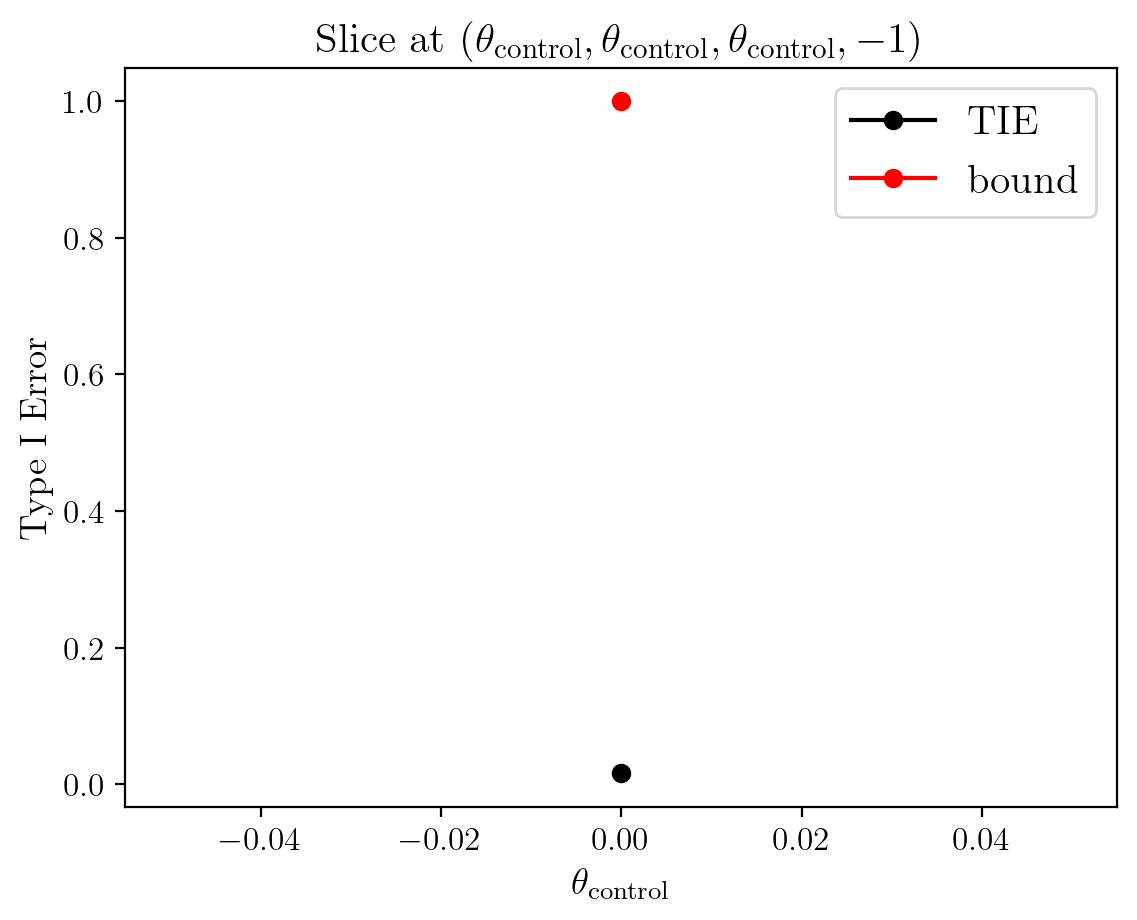

In [4]:
g = ip.cartesian_grid([-1], [1], n=[1])
rej_df = ip.validate(
    Model1D, g, lam=0.06253, K=2**20, tile_batch_size=1, model_kwargs=params
)
plt.plot(g.df["theta0"], rej_df["tie_est"], "k-o", label="TIE")
plt.plot(g.df["theta0"], rej_df["tie_bound"], "r-o", label="bound")
plt.xlabel("$\\theta_{\mathrm{control}}$")
plt.ylabel("Type I Error %")
plt.legend()
plt.title(
    "Slice at $(\\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, -1)$"
)
plt.show()

In [5]:
import time
import modal
import confirm.cloud.modal_util as modal_util

stub = modal.Stub("confirm")

img = modal_util.get_image()


@stub.function(
    image=img,
    # gpu=True,
    gpu=modal.gpu.A100(),
    retries=0,
    mounts=modal.create_package_mounts(["confirm"]),
    timeout=60 * 30,
)
def cloud_validate(g, K, params):
    start = time.time()
    rej_df = ip.validate(
        Model1D,
        g,
        lam=0.06253,
        K=K,
        tile_batch_size=256,
        model_kwargs=params,
    )
    print(time.time() - start)
    return rej_df

## [-1, 1] with $\theta_4 = -1$

In [6]:
g = ip.cartesian_grid([-1], [1], n=[2000])
with stub.run():
    rej_df = cloud_validate(g, 2**20, params)

Output()

✓ Initialized. View app at https://modal.com/apps/ap-rJr62rfvmFysuPmmO3nI9p

Output()

✓ Created objects.
├── 🔨 Created cloud_validate.
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm

Output()

779.5859432220459


✓ App completed.

In [10]:
rej_df.to_parquet("./1d_slice/1d_slice.parquet")

In [17]:
max_tile = g.df.loc[rej_df["tie_bound"].idxmax()]

In [18]:
max_tile

id           10248358921119991252
active                       True
eligible                     True
parent_id                       0
theta0                     0.4925
radii0                     0.0005
Name: 1492, dtype: object

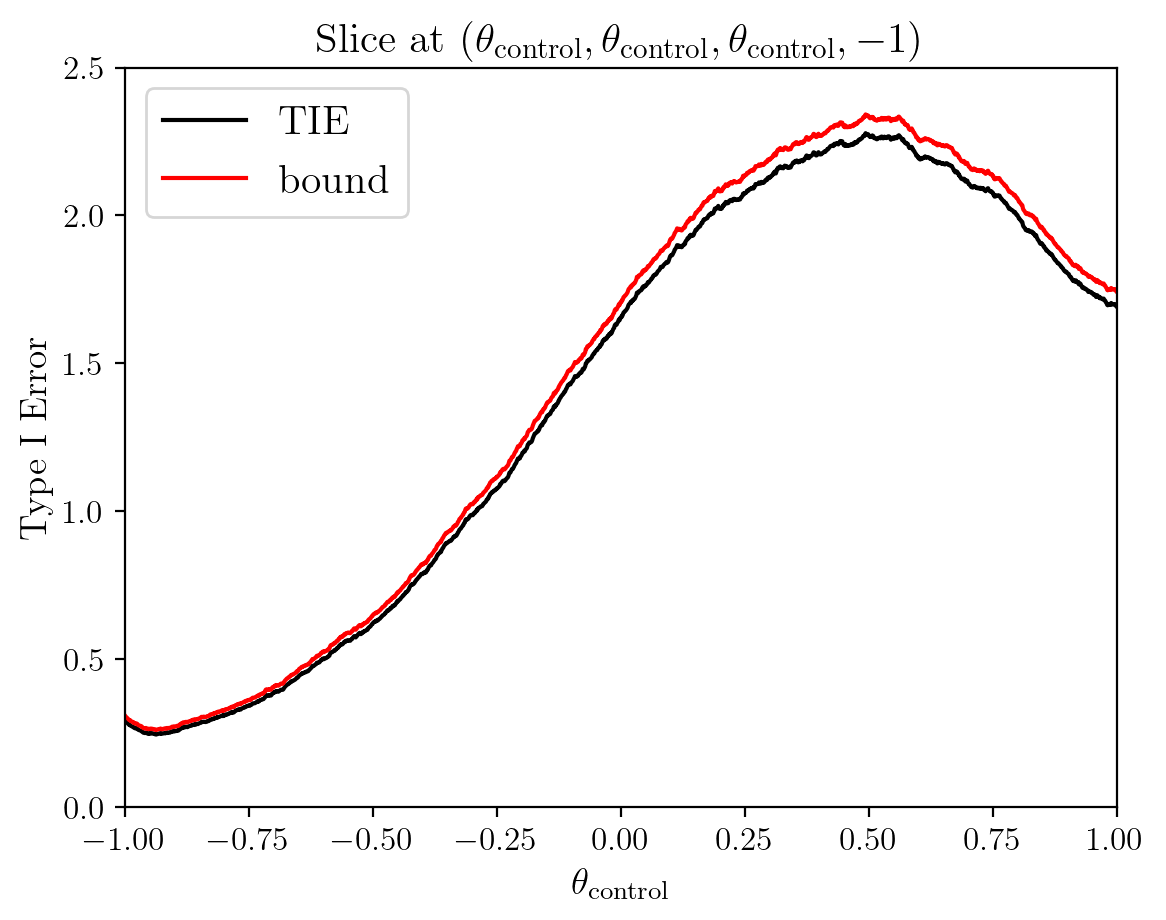

In [14]:
plt.plot(g.df["theta0"], 100 * rej_df["tie_est"], "k-", label="TIE")
plt.plot(g.df["theta0"], 100 * rej_df["tie_bound"], "r-", label="bound")
plt.xlim([-1, 1])
plt.ylim([0, 2.5])
plt.xlabel("$\\theta_{\mathrm{control}}$")
plt.ylabel("Type I Error %")
plt.legend()
plt.title(
    "Slice at $(\\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, -1)$"
)
plt.savefig("lewis_1d_slice.pdf", bbox_inches="tight")
plt.show()

## [-5, 5] with $\theta_4 = -1$

In [14]:
g = ip.cartesian_grid([-5], [5], n=[500])
with stub.run():
    rej_df = cloud_validate(g, 2**17, params)

Output()

✓ Initialized. View app at https://modal.com/apps/ap-vRnRYqd6munKsjuh8LlqDF

Output()

✓ Created objects.
├── 🔨 Created cloud_validate.
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm

Output()

66.54020595550537


✓ App completed.

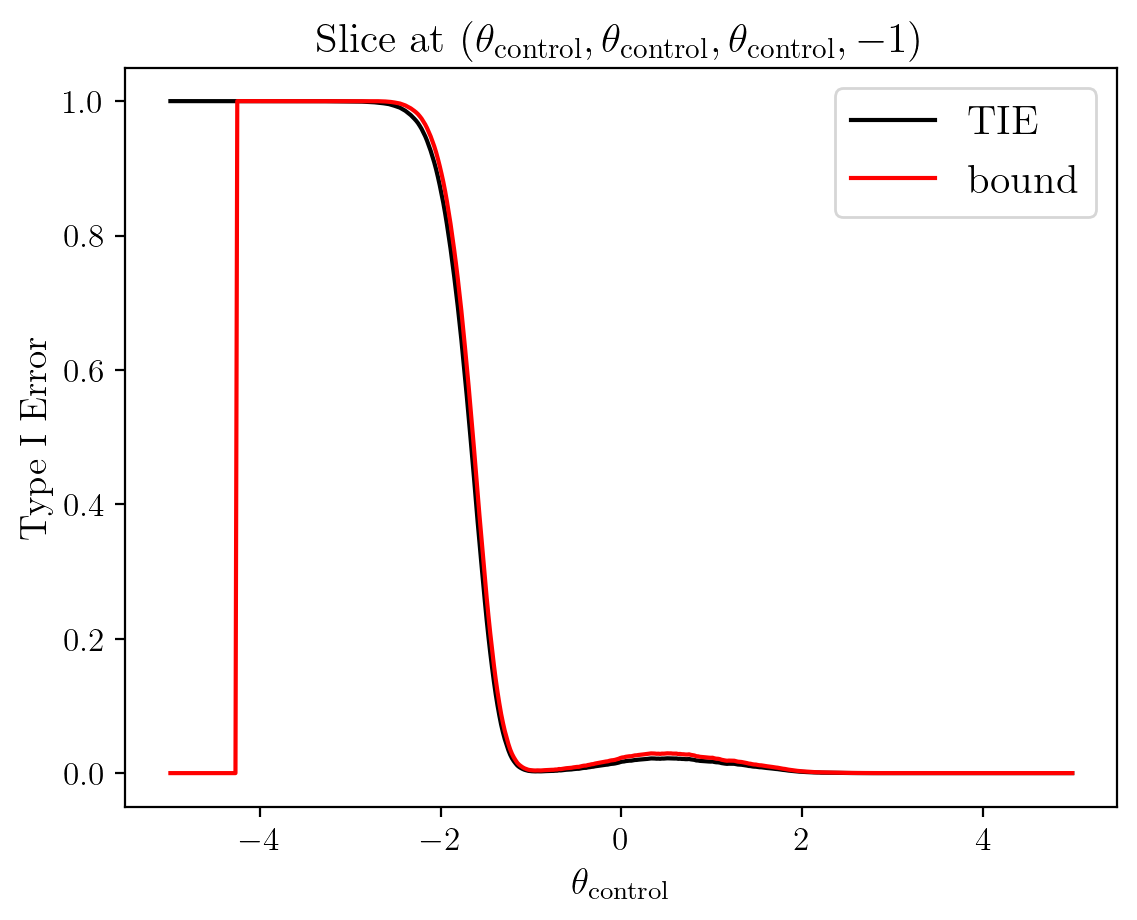

In [15]:
plt.plot(g.df["theta0"], rej_df["tie_est"], "k-", label="TIE")
plt.plot(g.df["theta0"], rej_df["tie_bound"], "r-", label="bound")
plt.xlabel("$\\theta_{\mathrm{control}}$")
plt.ylabel("Type I Error %")
plt.legend()
plt.title(
    "Slice at $(\\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, -1)$"
)
plt.show()

## [-1, 1] with $\theta_4 = -5$

In [22]:
g = ip.cartesian_grid([-3], [1], n=[1000])
params5 = params.copy()
params5["bad_arm"] = -5.0
with stub.run():
    rej_df = cloud_validate(g, 2**20, params5)

Output()

✓ Initialized. View app at https://modal.com/apps/ap-iEgcd55YX7g2djZSCJhW6L

Output()

✓ Created objects.
├── 🔨 Created cloud_validate.
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm

Output()

413.08967757225037


✓ App completed.

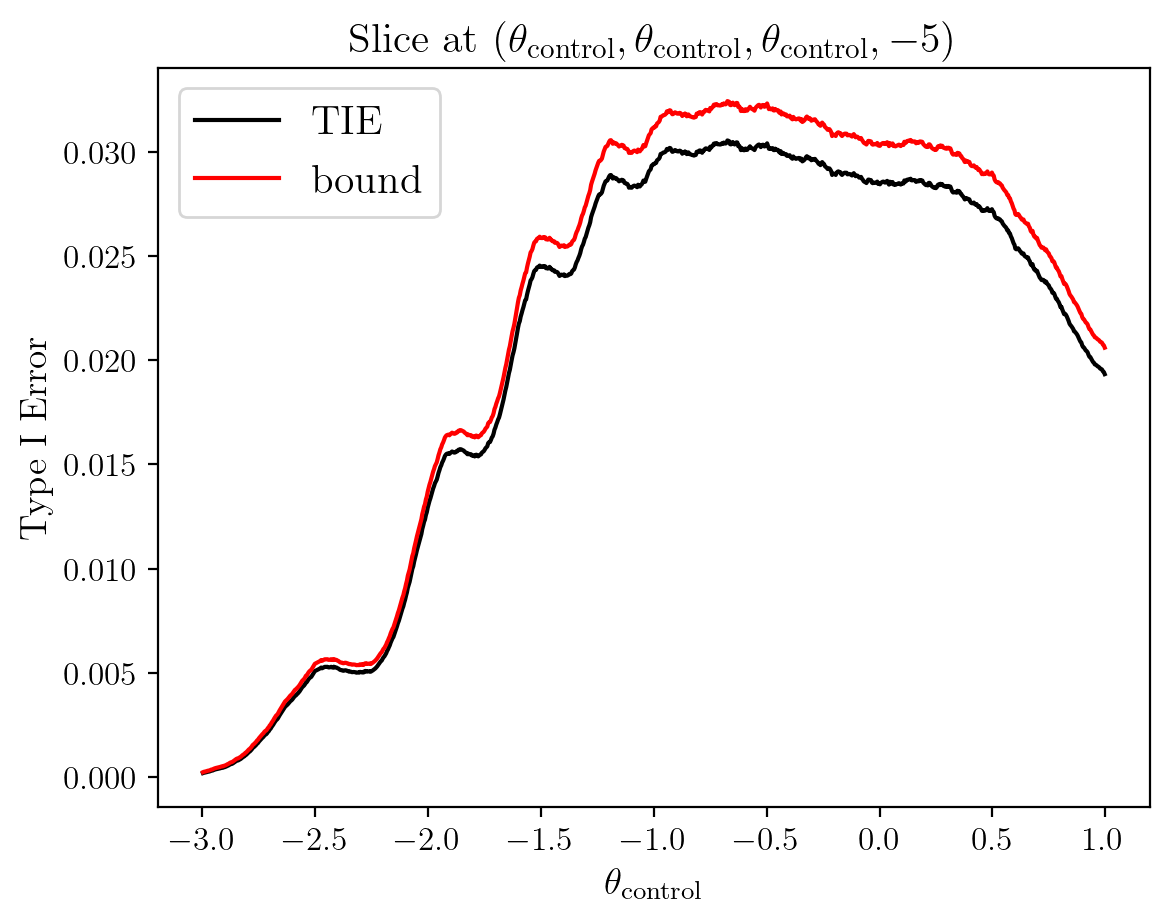

In [23]:
plt.plot(g.df["theta0"], rej_df["tie_est"], "k-", label="TIE")
plt.plot(g.df["theta0"], rej_df["tie_bound"], "r-", label="bound")
plt.xlabel("$\\theta_{\mathrm{control}}$")
plt.ylabel("Type I Error %")
plt.legend()
plt.title(
    "Slice at $(\\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, -5)$"
)
plt.show()

## Testing with AWS Batch instead of Modal.

In [5]:
import jax

name = "1d_slice"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
    "bad_arm": -1.0,
}

In [17]:
import confirm
import confirm.cloud.awsbatch as awsbatch
import boto3
import pickle


@awsbatch.include_package(confirm)
def job():
    from confirm.lewislib import lewis

    class Model1D:
        def __init__(self, seed, max_K, **kwargs):
            self.model = lewis.Lewis45Model(
                seed, max_K, **{k: v for k, v in kwargs.items() if k != "bad_arm"}
            )
            self.bad_arm = kwargs["bad_arm"]
            self.family = "binomial"
            self.family_params = {"n": int(self.model.lewis45.unifs_shape()[0])}

        def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
            control = theta[:, 0]
            theta = np.stack(
                (control, control, control, np.full_like(control, self.bad_arm)), axis=1
            )
            null_truth = np.full((theta.shape[0], 3), True)
            out = self.model.sim_batch(begin_sim, end_sim, theta, null_truth)
            return out

    import confirm.imprint as ip

    g = ip.cartesian_grid([-1], [1], n=[500])
    K = 2**17

    start = time.time()
    print("starting")
    rej_df = ip.validate(
        Model1D,
        g,
        lam=0.06253,
        K=K,
        tile_batch_size=256,
        model_kwargs=params,
    )
    print(time.time() - start)
    boto3.resource("s3").Object("imprint-dump", "result.pkl").put(
        Body=pickle.dumps(rej_df)
    )

In [11]:
awsbatch.local_test(job)

Loading job from S3


Traceback (most recent call last):
  File "/main.py", line 26, in <module>
    print(main())
  File "/main.py", line 16, in main
    f = cloudpickle.loads(data)
  File "/usr/local/lib/python3.10/dist-packages/jax/__init__.py", line 35, in <module>
    from jax import config as _config_module
  File "/usr/local/lib/python3.10/dist-packages/jax/config.py", line 17, in <module>
    from jax._src.config import config  # noqa: F401
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/config.py", line 27, in <module>
    from jax._src import lib
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 85, in <module>
    cpu_feature_guard.check_cpu_features()
RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. You may be able work around this issue by building jaxlib from source.


In [13]:
response, bucket, filename = awsbatch.remote_run(job, cpus=4, memory=2**15, gpu=True)

In [21]:
boto3.resource("s3").Bucket("imprint-dump").download_file("result.pkl", "result.pkl")
g = ip.cartesian_grid([-1], [1], n=[500])
with open("result.pkl", "rb") as f:
    rej_df = pickle.load(f)

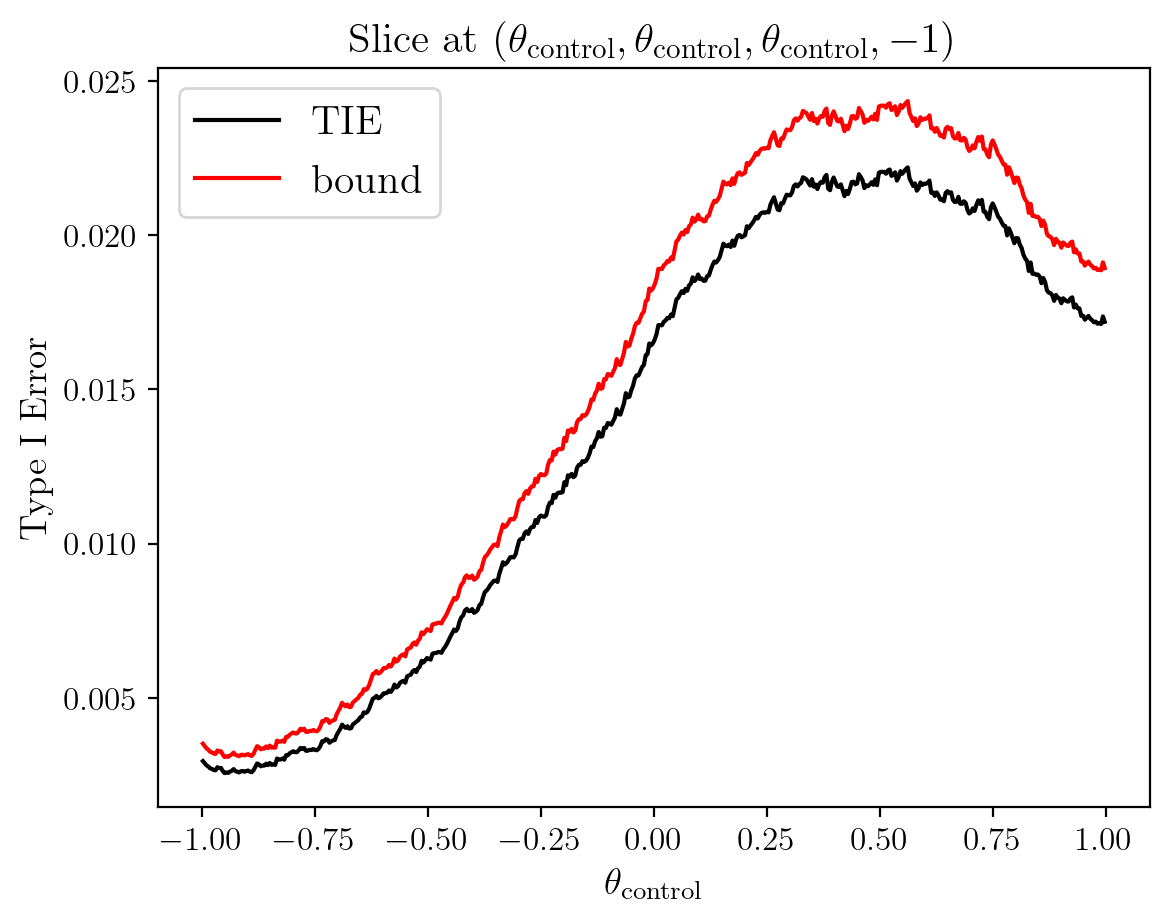

In [23]:
plt.plot(g.df["theta0"], rej_df["tie_est"], "k-", label="TIE")
plt.plot(g.df["theta0"], rej_df["tie_bound"], "r-", label="bound")
plt.xlabel("$\\theta_{\mathrm{control}}$")
plt.ylabel("Type I Error %")
plt.legend()
plt.title(
    "Slice at $(\\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, -1)$"
)
plt.show()